In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
t.manual_seed(2017)

 我们从data.txt读取数据，感兴趣的话可以将data.txt打开看看数据长啥样，建议打开数据文件看看数据，否则下面读取数据的部分可能有些难以理解

读入数据点后，我们根据不同label将将数据点分为蓝色和红色，并画图展示

In [6]:
#从data中读取数据点
with open('./data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]
    
#看过数据的话可以知道一行数据有三个数值，分别对应着x0,、x1两个特征和y这个标签值

In [7]:
#数据标准化
x0_max = max(i[0] for i in data)
x1_max = max(i[1] for i in data)
data = [(i[0] / x0_max, i[1] / x1_max, i[2]) for i in data]

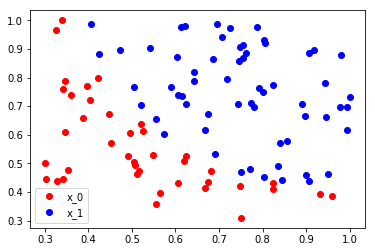

In [8]:
x0 = list(filter(lambda x:x[-1] == 0.0, data))#选择第一类的点，即标签值为0的点
x1 = list(filter(lambda x:x[-1] == 1.0, data))#选择第二类的点，即标签值为1的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label = 'x_0')
plt.plot(plot_x1, plot_y1, 'bo', label = 'x_1')
plt.legend(loc = 'best')

接下来我们将数据转换成numpy，然后转换成tensor，为之后的训练做准备

In [32]:
np_data = np.array(data, dtype = 'float32')  #转换成ndarray
x_data = t.from_numpy(np_data[:, 0:2])  #转换成tensor， 大小是[100,2]
y_data = t.from_numpy(np_data[:, -1]).unsqueeze(1) #转换成tensor，大小是[100, 1]，若不增加维度的话则y_data的维度是（100，）
x_data.requires_grad = True
y_data.requires_grad = True

下面我们来实现以下 Sigmoid 的函数，Sigmoid 函数的公式为

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

In [33]:
#定义sigmoid函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

画出 Sigmoid 函数，可以看到值越大，经过 Sigmoid 函数之后越靠近 1，值越小，越靠近 0

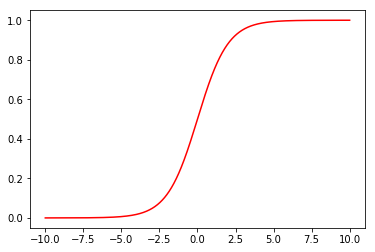

In [34]:
#画出sigmoid函数
plot_x = np.arange(-10, 10.01, 0.01)
plot_y = sigmoid(plot_x)

plt.plot(plot_x, plot_y, 'r')

在 PyTorch 当中，不需要我们自己写 Sigmoid 的函数，PyTorch 已经用底层的 C++ 语言为我们写好了一些常用的函数，不仅方便我们使用，同时速度上比我们自己实现的更快，稳定性更好

通过导入 `torch.nn.functional` 来使用，下面就是使用方法

In [35]:
#import torch.nn.functional as F
#更新到新版本之后，可以直接使用torch.sigmoid

In [42]:
#定义logistic 回归模型
w = t.randn(2, 1, requires_grad = True)
b = t.zeros(1).requires_grad_()

def logistic_regression(x, w, b):
    return t.sigmoid(t.mm(x,w) + b)

在更新之前，我们可以先画出分类的效果

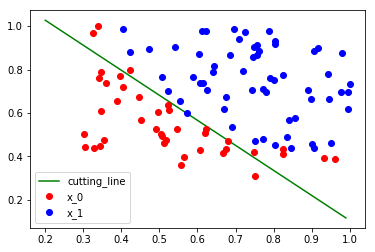

In [82]:
#画出参数更新之前的结果
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (- w0.numpy() * plot_x - b0.numpy()) / w1.numpy()

plt.plot(plot_x, plot_y, 'g', label = 'cutting_line')
plt.plot(plot_x0, plot_y0, 'ro', label = 'x_0')
plt.plot(plot_x1, plot_y1, 'bo', label = 'x_1')
plt.legend(loc = 'best')

可以看到分类效果基本是混乱的，我们来计算一下 loss，公式如下

$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$

In [83]:
#计算loss
def binary_loss(y_pred, y):
    loss = (y * y_pred.clamp(1e-12).log() + (1 - y) * (1 - y_pred).clamp(1e-12).log()).mean()
    return - loss

注意到其中使用 `.clamp`，这是[文档](http://pytorch.org/docs/0.3.0/torch.html?highlight=clamp#torch.clamp)的内容，查看一下，并且思考一下这里是否一定要使用这个函数，如果不使用会出现什么样的结果

**提示：查看一个 log 函数的图像**

我个人的理解是这个clamp是限定了y_pred的最小值为1e-12，因为log（x）当x趋于零时的值是无穷大

In [84]:
y_pred = logistic_regression(x_data, w, b)
loss = binary_loss(y_pred, y_data)
print(loss)

tensor(-0.0470, grad_fn=<NegBackward>)


得到loss之后，我们还是利用梯度下降法更新参数，这里使用自动求导来完成，感兴趣的朋友可以手动推导一下导数公式

In [85]:
#自动求导并更新参数
loss.backward()
w.data = w.data - 0.01 * w.grad.data
b.data = b.data - 0.01 * b.grad.data

y_pred = logistic_regression(x_data, w, b)
loss = binary_loss(y_pred, y_data)
print(loss)

tensor(-0.0470, grad_fn=<NegBackward>)


上面的参数更新方式其实是繁琐的重复操作，如果我们的参数很多，比如有 100 个，那么我们需要写 100 行来更新参数，为了方便，我们可以写成一个函数来更新，其实 PyTorch 已经为我们封装了一个函数来做这件事，这就是 PyTorch 中的优化器 `torch.optim`

使用 `torch.optim` 需要另外一个数据类型，就是 `nn.Parameter`，这个本质上和 Variable 是一样的，只不过 `nn.Parameter` 默认是要求梯度的，而 Variable 默认是不求梯度的

使用 `torch.optim.SGD` 可以使用梯度下降法来更新参数，PyTorch 中的优化器有更多的优化算法，在本章后面的课程我们会更加详细的介绍

将参数 w 和 b 放到 `torch.optim.SGD` 中之后，说明一下学习率的大小，就可以使用 `optimizer.step()` 来更新参数了，比如下面我们将参数传入优化器，学习率设置为 1.0

In [86]:
#使用torch.optim更新参数
from torch import nn
w = nn.Parameter(t.randn(2, 1))
b = nn.Parameter(t.zeros(1))

def logistic_regression(x, w, b):
    return t.sigmoid(t.mm(x, w) + b)

optimizer = t.optim.SGD([w, b], lr = 1.)

In [87]:
#进行1000次更新
import time
start = time.time()
for e in range(1000):
    #前向传播
    y_pred = logistic_regression(x_data, w, b)
    loss = binary_loss(y_pred, y_data)
    
    #反向传播
    optimizer.zero_grad()#使用优化器将梯度清零
    loss.backward()
    optimizer.step()
    
    
    if (e + 1 ) % 200 == 0:
        print('epoch:{}, loss:{:.5f}'.format(e + 1, loss.data[0]))

during = time.time()- start
print()
print("During Time :{:.3f}s".format(during))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


epoch:200, loss:0.38583
epoch:400, loss:0.31999
epoch:600, loss:0.28814
epoch:800, loss:0.26918
epoch:1000, loss:0.25654

During Time :0.558s


可以看到使用优化器之后更新参数非常简单，只需要在自动求导之前使用**`optimizer.zero_grad()`** 来归 0 梯度，然后使用 **`optimizer.step()`**来更新参数就可以了，非常简便

同时经过了 1000 次更新，loss 也降得比较低了

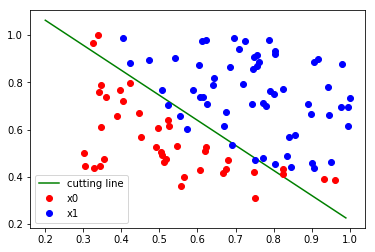

In [64]:
#画出更新之后的结果
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0.numpy() * plot_x - b0.numpy()) / w1.numpy()

plt.plot(plot_x, plot_y, 'g', label = 'cutting line')
plt.plot(plot_x0, plot_y0, 'ro', label = 'x0')
plt.plot(plot_x1, plot_y1, 'bo', label = 'x1')
plt.legend(loc = 'best')

前面我们使用了自己写的 loss，其实 PyTorch 已经为我们写好了一些常见的 loss，比如线性回归里面的 loss 是 `nn.MSE()`，而 Logistic 回归的二分类 loss 在 PyTorch 中是 `nn.BCEWithLogitsLoss()`，关于更多的 loss，可以查看[文档](http://pytorch.org/docs/0.3.0/nn.html#loss-functions)

PyTorch 为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

另外，PyTorch 出于稳定性考虑，将模型的 Sigmoid 操作和最后的 loss 都合在了 `nn.BCEWithLogitsLoss()`，所以我们使用 PyTorch 自带的 loss 就不需要再加上 Sigmoid 操作了

In [76]:
#使用自带的loss
criterion = nn.BCEWithLogitsLoss() #将sigmoid和loss写在一起，有更快的速度和更好的稳定性

w = nn.Parameter(t.randn(2, 1))
b = nn.Parameter(t.zeros(1))

def logistic_regression(x, w, b):
    return t.mm(x, w) + b

optimizer = t.optim.SGD([w, b], lr = 1.)

In [77]:
y_pred = logistic_regression(x_data, w, b)  #这里的y_pred和之前的不同，之前的y_pred是经过了sigmoid函数的结果
loss = criterion(y_pred, y_data)
print(loss.data)

tensor(0.9912)


In [78]:
#同样进行1000次更新
start = time.time()
for e in range(1000):
    y_pred = logistic_regression(x_data, w, b)
    loss = criterion(y_pred, y_data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}'.format(e+1, loss.data[0]))

during = time.time() - start
print()
print('During Time: {:.3f} s'.format(during))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


epoch: 200, Loss: 0.40971
epoch: 400, Loss: 0.32977
epoch: 600, Loss: 0.29346
epoch: 800, Loss: 0.27254
epoch: 1000, Loss: 0.25886

During Time: 0.378 s


可以看到，使用了 PyTorch 自带的 loss 之后，速度有了一定的上升，虽然看上去速度的提升并不多，但是这只是一个小网络，对于大网络，使用自带的 loss 不管对于稳定性还是速度而言，都有质的飞跃，同时也避免了重复造轮子的困扰